In [85]:
## Load Imports

from opacus_new.accountants import RDPAccountant
from opacus_new.accountants.utils import get_sample_rate, get_noise_multiplier
import numpy as np
import warnings
# Suppress specific warnings
warnings.filterwarnings("ignore", message="Secure RNG turned off.*")
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [86]:
aggregator = np.mean
list_of_epsilons = [1, 8]
delta = 1e-5
max_grad_norm = 1.0
n_steps = 100
list_highest = [16, 32, 64, 128, 256]
list_mean = list_highest# [10, 12, 14, 16, 18]
nm = {k:get_noise_multiplier(target_epsilon=aggregator(np.array([*list_of_epsilons, k])), target_delta=delta, sample_rate=0.1, epochs=n_steps, accountant='rdp') for k in list_mean}

print(nm)


/vol/miltank/users/kaiserj/Clipping_vs_Sampling/opacus_new/accountants/analysis/rdp.py:340: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


{16: 2.108154296875, 32: 1.492919921875, 64: 1.0601806640625, 128: 0.7781982421875, 256: 0.5902099609375}


In [87]:

sample_rates_1 = {n:{
    k: 1 if k == n
       else get_sample_rate(target_epsilon=k, target_delta=delta,
                            noise_multiplier=nm[n], steps=n_steps, accountant='rdp')
    for k in list_of_epsilons
}
for n in list_mean}
print(sample_rates_1)

/vol/miltank/users/kaiserj/Clipping_vs_Sampling/opacus_new/accountants/analysis/rdp.py:340: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


{16: {1: 0.044403077127471935, 8: 0.2988281257011719}, 32: {1: 0.027114869136947634, 8: 0.19250488361999513}, 64: {1: 0.009033204115966798, 8: 0.11285400479339602}, 128: {1: 0.0004596720200481415, 8: 0.057495118130004894}, 256: {1: 2.688796947652474e-06, 8: 0.022613526368011477}}


In [88]:
def compute_epsilon_delta(noise_multiplier, deltas, iterations, sampling_rate, clipping_norm):
    accountant = RDPAccountant()
    for _ in range(int(iterations)):
        accountant.step(noise_multiplier=noise_multiplier * 1/clipping_norm, sample_rate=sampling_rate)
    epsilons = []
    deltas2 = []
    for delta in deltas:
        epsilon = accountant.get_epsilon(delta)
        epsilons.append(epsilon)
        deltas2.append(delta)
    return epsilons, deltas2

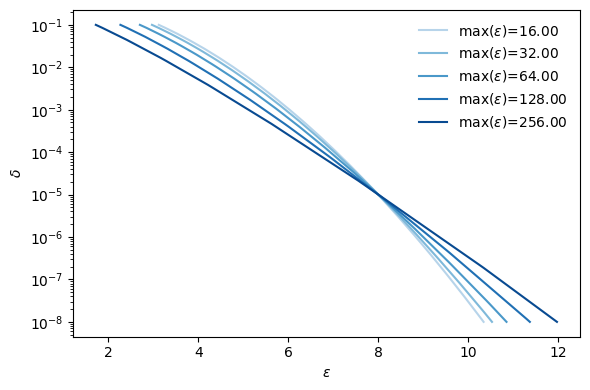

In [90]:
import matplotlib.pyplot as plt
import numpy as np

deltas = np.logspace(-8, -1, 100)

plt.figure(figsize=(6,4))

# pick equally spaced shades from the Blues colormap
colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(list_mean)))

for idx, k in enumerate(list_mean):
    noise = nm[k]
    sr = sample_rates_1[k][8]
    epsilons_1, deltas_1 = compute_epsilon_delta(
        noise_multiplier=noise,
        deltas=deltas,
        iterations=n_steps,
        sampling_rate=sr,
        clipping_norm=max_grad_norm
    )
    plt.semilogy(
        epsilons_1, deltas_1,
        color=colors[idx],
        label=fr'max($\varepsilon$)={k:.2f}'
    )

plt.xlabel(r'$\varepsilon$')
plt.ylabel(r'$\delta$')

# plt.grid(True, which="both", ls="--", lw=0.5, alpha=0.7)
plt.legend(frameon=False)

plt.tight_layout()
plt.savefig("/vol/miltank/users/kaiserj/Clipping_vs_Sampling/extra_figs/no_batch_max.png", dpi=300)
plt.savefig("/vol/miltank/users/kaiserj/Clipping_vs_Sampling/extra_figs/no_batch_max.svg", dpi=300)
plt.show()
